In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#redimensionnement d'image pour le détecteur Detectron

In [ ]:
def resize(scale_percent, image_path):
    # Charger l'image
    image = cv2.imread(image_path)

    # Calculer les nouvelles dimensions en fonction du pourcentage de redimensionnement
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Redimensionner l'image en utilisant l'interpolation de l'aire
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    return resized

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow












#detectron Installation

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=f7a15f2c76f16e4d31a391e127d337600d8a8989d3dc3887111c45b0cf482a01
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer


ModuleNotFoundError: ignored

#Enregistrement de jeu de données et configuration de métadonnées pour l'entraînement et la validation

la structure du fichier json resultat de l'annotation

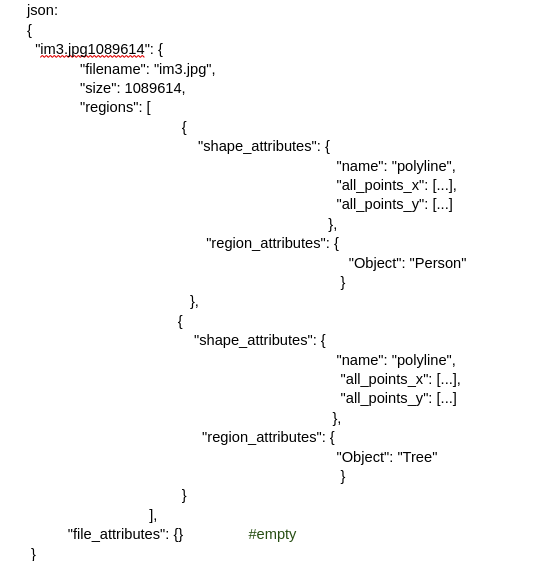



In [ ]:
def get_tree_dicts(img_dir):
    # Charger le fichier JSON contenant les annotations des images
    json_file = os.path.join(img_dir, "annotations_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    classes = ['Tree', 'Person']
    dataset_dicts = []

    # Parcourir chaque image annotée
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        # Chemin d'accès complet à l'image
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        print(len(annos))
        objs = []

        # Parcourir chaque annotation dans l'image
        for x in range(len(annos)):
            anno = annos[x]["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            # Créer l'objet d'annotation avec les informations nécessaires
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(annos[x]["region_attributes"]['Object']),
                "iscrowd": 0
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts



 l'ajout de 0.5 aux coordonnées x et y des points dans poly est une pratique courante pour améliorer la précision et l'alignement des annotations de régions dans certains cas, notamment lors de la détection d'objets.

get_tree_dicts ouput :

dataset_dicts[
  record {
    filename : ,image_id , heigth: , width: ,
annotations : {bbox: [min(px), min(py),max(px),max(py)] ,bbox_mode:  the bounding box coordinates the top-left and bottom-right corners of the box within the image , segmentation : [(x+0.5,y+0.5),.....],category_id: Person , iscrowd:0}
      }
      ]



  dataset of detectron:
  1. datax_train :

*   dataset catalog : dataset_dicts(Data_Resized/train)
*   metadataCatalogue : thing_classes=["Tree","Person"]
2. datax_test :

*   dataset catalog : dataset_dicts(Data_Resized/test)
*   metadataCatalogue : thing_classes=["Tree","Person"]



In [ ]:
# Enregistrer les datasets d'entraînement et de validation avec leurs annotations
for d in ["train", "val"]:
    DatasetCatalog.register("datax_" + d, lambda d=d: get_tree_dicts("/content/drive/MyDrive/olive/data_object_detection_olivier/" + d))
    MetadataCatalog.get("datax_" + d).set(thing_classes=["Tree","Person"])

# Obtenir les métadonnées du dataset d'entraînement
tree_metadata = MetadataCatalog.get("datax_train")

#Entraînement d'un modèle de détection d'instances avec Detectron2

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import os
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer

In [ ]:


class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:



# Obtenir la configuration par défaut
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/olive/data_object_detection_olivier/"
# Fusionner la configuration avec un fichier de configuration pré-entraîné spécifique (mask_rcnn_X_101_32x8d_FPN_3x.yaml).
# Cela permet de charger les paramètres et les hyperparamètres prédéfinis pour ce modèle.
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Définir le dataset d'entraînement
cfg.DATASETS.TRAIN = ("datax_train",)

# Définir le dataset de test (aucun dans ce cas)
cfg.DATASETS.TEST = ()

# Configurer le nombre de travailleurs de chargement des données (NUM_WORKERS),
# qui détermine le nombre de processus utilisés pour charger les données en parallèle.
cfg.DATALOADER.NUM_WORKERS = 2

# Poids initiaux du modèle
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo

# Set the number of images per batch
cfg.SOLVER.IMS_PER_BATCH = 2

# Set the base learning rate
cfg.SOLVER.BASE_LR = 0.00025

# Set the number of warm-up iterations
cfg.SOLVER.WARMUP_ITERS = 200

# Set the total number of training iterations
cfg.SOLVER.MAX_ITER = 500

# Set the learning rate schedule steps
cfg.SOLVER.STEPS = (400,)

# Set the learning rate decay
cfg.SOLVER.GAMMA = 0.1

# Set the batch size per image
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# Set the number of classes (e.g., 2: Tree and Person)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# Use the CPU for training
cfg.MODEL.DEVICE = 'cuda'

# Create the output directory if it doesn't exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create the DefaultTrainer object with the configuration
trainer = DefaultTrainer(cfg)

# Load pre-trained weights or resume training from a checkpoint
trainer.resume_or_load(resume=False)

# Start training the model
#trainer.train()













[06/19 11:07:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:01, 256MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:

# Chemin d'accès au fichier de poids du modèle pré-entrainé
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/olive/data_object_detection_olivier/model_final.pth"

# Seuil de score pour les prédictions lors du test
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95

# Définir le dataset de test (dans ce cas, le dataset de validation)
cfg.DATASETS.TEST = ("datax_val", )

# Créer un prédicteur par défaut en utilisant la configuration
predictor = DefaultPredictor(cfg)


[06/19 11:07:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/olive/data_object_detection_olivier/model_final.pth ...


#Visualisation des prédictions d'instances sur le dataset de validation

In [ ]:

# Obtenir les dictionnaires de données du dataset de validation
dataset_dicts = get_tree_dicts("/content/drive/MyDrive/olive/data_object_detection_olivier/val")

# Sélectionner aléatoirement 2 exemples d'images du dataset de validation
for d in random.sample(dataset_dicts, 2):
    # Charger l'image
    im = cv2.imread(d["file_name"])

    # Effectuer des prédictions sur l'image en utilisant le prédicteur
    outputs = predictor(im)

    # Créer un visualiseur avec l'image et les métadonnées
    v = Visualizer(im[:, :, ::-1], metadata=tree_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)

    # Dessiner les prédictions d'instances sur l'image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Afficher l'image avec les prédictions
    plt.figure(figsize=(15, 18))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


    # Get the segmented masks
    masks = outputs["instances"].pred_masks

    # Convert masks to numpy array
    masks_np = masks.cpu().numpy()

    # Create a blank image to store the segmented part
    segmented_image = np.zeros_like(im)

    # Apply the masks to the segmented image
    for mask in masks_np:
      segmented_image[mask] = im[mask]

    # Display the segmented part
    plt.imshow(segmented_image)
    plt.show()


2
2


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: ignored

In [1]:
"""
import os
import cv2
# Obtenir les dictionnaires de données du dataset de validation
directory='/content/drive/MyDrive/olive/data/'
save_dir='/content/drive/MyDrive/olive/boxe/'
# Sélectionner aléatoirement 2 exemples d'images du dataset de validation
for filename in os.listdir(directory):
    # Full path of the image
    filepath = os.path.join(directory, filename)
    # Load the image
    im = cv2.imread(filepath)
    # Effectuer des prédictions sur l'image en utilisant le prédicteur
    outputs = predictor(im)

    # Créer un visualiseur avec l'image et les métadonnées
    v = Visualizer(im[:, :, ::-1], metadata=tree_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)

    # Dessiner les prédictions d'instances sur l'image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))


    # Afficher l'image avec les prédictions

    plt.figure(figsize=(15, 18))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()



"""

'\nimport os\nimport cv2\n# Obtenir les dictionnaires de données du dataset de validation\ndirectory=\'/content/drive/MyDrive/olive/data/\'\nsave_dir=\'/content/drive/MyDrive/olive/boxe/\'\n# Sélectionner aléatoirement 2 exemples d\'images du dataset de validation\nfor filename in os.listdir(directory):\n    # Full path of the image\n    filepath = os.path.join(directory, filename)\n    # Load the image\n    im = cv2.imread(filepath)\n    # Effectuer des prédictions sur l\'image en utilisant le prédicteur\n    outputs = predictor(im)\n\n    # Créer un visualiseur avec l\'image et les métadonnées\n    v = Visualizer(im[:, :, ::-1], metadata=tree_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)\n\n    # Dessiner les prédictions d\'instances sur l\'image\n    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n\n    save_path = os.path.join(save_dir, filename)\n    cv2.imwrite(save_path, cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))\n\n\n    # Afficher l\'im

In [ ]:
"""
import os
import cv2
# Obtenir les dictionnaires de données du dataset de validation
directory='/content/drive/MyDrive/olive/augmented_data/'
save_dir='/content/drive/MyDrive/olive/bounding_box/'
# Sélectionner aléatoirement 2 exemples d'images du dataset de validation
for filename in os.listdir(directory):
    # Full path of the image
    filepath = os.path.join(directory, filename)
    # Load the image
    im = cv2.imread(filepath)
    # Effectuer des prédictions sur l'image en utilisant le prédicteur
    outputs = predictor(im)

    # Créer un visualiseur avec l'image et les métadonnées
    v = Visualizer(im[:, :, ::-1], metadata=tree_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)

    # Dessiner les prédictions d'instances sur l'image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))


    # Afficher l'image avec les prédictions
    plt.figure(figsize=(15, 18))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()



"""

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#Dataset for resnet

Tree(h1,w1)
Person(h2,w2)

Tree_height = (h1/h2)*1.7
Tree_width= (Tree_height/h1)*w1



[
   {
      "filename": "/content/output/bounding_box/bbox_0.jpg",
      "Tree_height": 3.8214771364184092,
      "Tree_Width": 4.996759928962184
   },
   {
      "filename": "/content/output/bounding_box/bbox_1.jpg",
      "Tree_height": 4.289722472181375,
      "Tree_Width": 5.056172223075741
   }
]

#Annotation pour ResNet

In [ ]:

from PIL import Image
import glob
cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

def bound_box(data_path):
    j = 0


    # Parcourir toutes les images dans le répertoire spécifié
    liste=[]
    for x in glob.glob(data_path + "/*.jpg"):
        print(x)
        im = resize(60, x)
        # Effectuer des prédictions sur l'image en utilisant le prédicteur
        outputs = predictor(im)
        print('outputs=',outputs)
        y1=0
        y2=0
        x1=0
        x2=0
        y21=0
        y22=0
        print("******************************",len(outputs["instances"].pred_classes))
        # Parcourir toutes les instances prédites
        for i in range(len(outputs["instances"].pred_classes)):

            if outputs["instances"].pred_classes[i] == 0:
                y1 = int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][1])
                y2 = int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][3])
                x1 = int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][0])
                x2 = int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][2])
                print("y1",y1)
                print("y2",y2)
                h1=y2-y1
                w1=x2-x1
            if outputs["instances"].pred_classes[i] == 1:
                if ((int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][3])-int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][1]))>y22-y21):
                  y22=int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][3])
                  y21=int(outputs["instances"].pred_boxes[i].tensor.cpu().numpy()[0][1])
                  h2=y22-y21
                  print("y21",y21)
                  print("y22",y22)
        print("h1", h1 )
        print("w1", w1 )
        print("h2", h2 )
        if(h1!=0):
          Tree_height=(h1/h2)*1.7
          Tree_Width=Tree_height/h1*w1
        else:
          Tree_height=0
          Tree_Width=0
        liste.append({"filename":data_path + x,"Tree_height":Tree_height ,"Tree_Width":Tree_Width})

    with open('/content/drive/MyDrive/olive/Tree_height.txt', 'w') as f:
                        f.write(json.dumps(liste))



In [ ]:
bound_box("/content/drive/MyDrive/olive/eq_augmented_data")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        [ 268.1675,   35.7920, 1701.7531, 1261.6241]], device='cuda:0')), scores: tensor([0.9908, 0.9842], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]]

In [ ]:


fin = open("/content/drive/MyDrive/olive/Tree_height.txt", "r")  # Ouvrir le fichier source en lecture
fout = open("/content/drive/MyDrive/olive/Tree_height1.txt", "wt")  # Créer un nouveau fichier texte pour écrire les modifications

# Parcourir les lignes du fichier source
for line in fin:
    fout.write(line.replace('/content/drive/MyDrive/olive/eq_augmented_data/content/drive/MyDrive/olive/eq_augmented_data/', ''))  # Remplacer la chaîne '/content/output' par une chaîne vide et écrire la ligne modifiée dans le fichier de sortie

fin.close()  # Fermer le fichier source
fout.close()  # Fermer le fichier de sortie


In [ ]:

my_file = open("/content/drive/MyDrive/olive/Tree_height1.txt", "r")  # Ouvrir le fichier en lecture
data = my_file.read()  # Lire le contenu du fichier

# Remplacer les fins de ligne ('\n') par un espace et les caractères '[' et ']' par un espace
# puis diviser le texte en une liste en utilisant '},' comme délimiteur
data_into_list = data.replace('\n', ' ').replace('[', ' ').replace(']', ' ').split("},")
# Parcourir les éléments de la liste et remplacer les caractères '{' et '}' par un espace
for i in range(len(data_into_list)):
    data_into_list[i] = data_into_list[i].replace('{', ' ').replace('}', ' ')

# Imprimer le deuxième élément de la liste
print(data_into_list[1])

my_file.close()  # Fermer le fichier


  "filename": "IMG_20210603_074354.jpg", "Tree_height": 2.657163323782235, "Tree_Width": 3.2977077363896847


In [ ]:

import pandas as pd

# Création d'un DataFrame vide avec les colonnes 'filename', 'height' et 'width'
df = pd.DataFrame(columns=['filename', 'height', 'width'])

# Parcourir les éléments de la liste data_into_list (jusqu'à l'indice 13 inclus)
for num in range(len(data_into_list)):
    # Nettoyage de l'élément en supprimant les espaces en double, remplaçant '//' par '/' et en divisant par ','
    x = data_into_list[num].replace('      ', '').replace('//', '/').split(',')
    # Extraction du nom de fichier en supprimant les guillemets et en remplaçant 'jpg ' par 'jpg'
    filename = x[0].split(': ')[1].replace('"', '').replace('jpg ', 'jpg')
    # Extraction de la hauteur en convertissant en float et arrondissant à 2 décimales
    height = round(float(x[1].split(': ')[1]), 2)
    # Extraction de la largeur en convertissant en float et arrondissant à 2 décimales
    width = round(float(x[2].split(': ')[1]), 2)
    # Ajout des valeurs dans le DataFrame
    df = df.append({'filename': filename, 'height': height, 'width': width}, ignore_index=True)


<ipython-input-18-7aad1387a4ea>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename': filename, 'height': height, 'width': width}, ignore_index=True)
<ipython-input-18-7aad1387a4ea>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename': filename, 'height': height, 'width': width}, ignore_index=True)
<ipython-input-18-7aad1387a4ea>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename': filename, 'height': height, 'width': width}, ignore_index=True)
<ipython-input-18-7aad1387a4ea>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename': filename, 'h

In [ ]:
df

,filename,height,width
0,IMG_20210603_083350_5.jpg,2.96,3.90
1,IMG_20210603_074354.jpg,2.66,3.30
2,im8_4.jpg,2.68,2.94
3,IMG_20220223_140547_3.jpg,2.63,3.31
4,IMG_20220223_122127_5.jpg,3.13,3.47
...,...,...,...
395,im14_5_translation_10.jpg,0.81,0.64
396,im12_2_8_translation_6.jpg,0.61,0.66
397,im12_2_8_rotation_6.jpg,0.61,0.68
398,im12_2_8_zoom_6.jpg,0.60,0.66


In [ ]:
# Exporter le DataFrame vers un fichier CSV
df.to_csv('/content/drive/MyDrive/olive/Tree_height.csv', index=False)


In [ ]:
import pandas as pd

# Read the CSV file
data = pd.read_csv('/content/drive/MyDrive/olive/Tree_height.csv')

# Initialize counters
small_count = 0
small_name=[]
med_count = 0
med_name=[]
big_count = 0
vbig_count = 0
vbig_name=[]
print("min=",min(data['height']))
print("max=",max(data['height']))
# Iterate over the 'height' column
i=0
for height in data['height']:

    if (height <= 1.5) and (height > 0):
        small_count += 1
        small_name.append(data["filename"][i])
    elif (1.5 < height)and (height<=2.5):
        med_count += 1
        med_name.append(data["filename"][i])
    elif (2.5 < height )and (height<= 3.5):
        big_count += 1
    elif height > 3.5:
        vbig_count += 1
        vbig_name.append(data["filename"][i])
    i=i+1

# Print the counts
print("small++ count:", small_count)
print("med+++ count:", med_count)
print("big++ count:", big_count)
print("vbig++ count:", vbig_count)
print("list of small",small_name)
print("list of med",med_name)
print("list of vbig",vbig_name)

min= 0.58
max= 4.78
small++ count: 99
med+++ count: 100
big++ count: 100
vbig++ count: 101
list of small ['md4_5.jpg', 'md4_4.jpg', 'im12_2.jpg', 'im14_5.jpg', 'im12.jpg', 'md4_3.jpg', 'im13.jpg', 'im13_5.jpg', 'md4_2.jpg', 'im12_1.jpg', 'im12_5.jpg', 'md7.jpg', 'im14_4.jpg', 'im12_3.jpg', 'im13_2.jpg', 'im13_1.jpg', 'im14_1.jpg', 'im14.jpg', 'im14_3.jpg', 'im13_3.jpg', 'im13_4.jpg', 'im14_2.jpg', 'md4_1.jpg', 'md4.jpg', 'md4_5_6.jpg', 'md4_5_8.jpg', 'md4_5_7.jpg', 'md4_5_9.jpg', 'md4_5_10.jpg', 'im12_2_6.jpg', 'im12_2_7.jpg', 'im12_2_8.jpg', 'md4_5_zoom_6.jpg', 'md4_5_rotation_6.jpg', 'md4_5_translation_8.jpg', 'md4_5_translation_7.jpg', 'md4_5_flip_7.jpg', 'md4_5_rotation_8.jpg', 'md4_5_zoom_8.jpg', 'md4_5_flip_8.jpg', 'md4_5_flip_9.jpg', 'md4_5_zoom_10.jpg', 'md4_5_flip_10.jpg', 'md4_5_rotation_10.jpg', 'im12_2_flip_6.jpg', 'im12_2_rotation_7.jpg', 'im12_2_rotation_8.jpg', 'im12_2_zoom_8.jpg', 'im12_2_translation_9.jpg', 'im12_2_flip_9.jpg', 'im12_2_rotation_10.jpg', 'md4_4_translat

#segmentation des image pour ResNet50

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import pandas as pd
import torch

In [ ]:
"""
import random
import cv2

# Path to the directory containing the images
directory = '/content/drive/MyDrive/olive/eq_augmented_data'

con=0
# Traverse all images in the directory
for filename in os.listdir(directory):
  filepath = os.path.join(directory, filename)
  # Load the image
  im= cv2.imread(filepath)
  # Effectuer des prédictions sur l'image en utilisant le prédicteur
  outputs = predictor(im)
  # Get the predicted classes and segmented masks
  pred_classes = outputs["instances"].pred_classes
  masks = outputs["instances"].pred_masks
  # Convert masks to numpy array
  masks_np = masks.cpu().numpy()
  # Create a blank image to store the segmented part
  segmented_image = np.zeros_like(im)
  # Apply the masks to the segmented image
  for i, mask in enumerate(masks_np):
    if pred_classes[i] == 0:
      segmented_image[mask] = im[mask]

  #plt.imshow(segmented_image)
  #plt.show()
  # Create the output directory if it doesn't exist
  output_dir = "/content/drive/MyDrive/olive/segmeted/"
  os.makedirs(output_dir, exist_ok=True)

  # Save the segmented image
  output_path = os.path.join(output_dir, filename)
  cv2.imwrite(output_path, segmented_image)
  con=con+1
  print("*****************************************con",con)
"""

'\nimport random\nimport cv2\n\n# Path to the directory containing the images\ndirectory = \'/content/drive/MyDrive/olive/eq_augmented_data\'\n\ncon=0\n# Traverse all images in the directory\nfor filename in os.listdir(directory):\n  filepath = os.path.join(directory, filename)\n  # Load the image\n  im= cv2.imread(filepath)\n  # Effectuer des prédictions sur l\'image en utilisant le prédicteur\n  outputs = predictor(im)\n  # Get the predicted classes and segmented masks\n  pred_classes = outputs["instances"].pred_classes\n  masks = outputs["instances"].pred_masks\n  # Convert masks to numpy array\n  masks_np = masks.cpu().numpy()\n  # Create a blank image to store the segmented part\n  segmented_image = np.zeros_like(im)\n  # Apply the masks to the segmented image\n  for i, mask in enumerate(masks_np):\n    if pred_classes[i] == 0:\n      segmented_image[mask] = im[mask]\n\n  #plt.imshow(segmented_image)\n  #plt.show()\n  # Create the output directory if it doesn\'t exist\n  output_di